# Congressional Voting Data Set

In [167]:
%pip install -r requirements.txt -q


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

## Loading Data

In [169]:
df_voting = pd.read_csv('data/CongressionalVotingID.shuf.lrn.csv')
df_voting_test = pd.read_csv('data/CongressionalVotingID.shuf.tes.csv')

## Data Description

In [170]:
display(df_voting.head(5))
df_voting.info(verbose=True)

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,democrat,y,n,y,n,y,y,y,n,y,y,n,n,y,y,n,unknown
1,86,democrat,n,n,y,n,y,y,n,n,n,y,y,y,y,y,n,y
2,264,democrat,y,n,y,n,n,n,y,y,y,n,n,n,n,n,y,unknown
3,258,republican,n,n,n,y,y,n,n,n,n,n,n,y,n,y,unknown,y
4,381,democrat,y,y,y,n,n,y,unknown,y,y,n,y,n,y,n,y,y


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   ID                                      218 non-null    int64 
 1   class                                   218 non-null    object
 2   handicapped-infants                     218 non-null    object
 3   water-project-cost-sharing              218 non-null    object
 4   adoption-of-the-budget-resolution       218 non-null    object
 5   physician-fee-freeze                    218 non-null    object
 6   el-salvador-aid                         218 non-null    object
 7   religious-groups-in-schools             218 non-null    object
 8   anti-satellite-test-ban                 218 non-null    object
 9   aid-to-nicaraguan-contras               218 non-null    object
 10  mx-missile                              218 non-null    object
 11  immigr

This data set has 218 entries and 18 attributes. The target value of this data set is class so what party the people are part of. We want in this classification task to predict based on the questions voters answered with either yes "y" or no "n". So the rest of the attributes are all binary data. There are no missing values per se but some questions were answered with unkown so we have to look how we want to deal with this missing values.

Index(['ID', 'class', 'handicapped-infants', 'water-project-cost-sharing',
       'adoption-of-the-budget-resolution', 'physician-fee-freeze',
       'el-salvador-aid', 'religious-groups-in-schools',
       'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
       'immigration', 'synfuels-crporation-cutback', 'education-spending',
       'superfund-right-to-sue', 'crime', 'duty-free-exports',
       'export-administration-act-south-africa'],
      dtype='object')

41.74311926605505

58.256880733944946

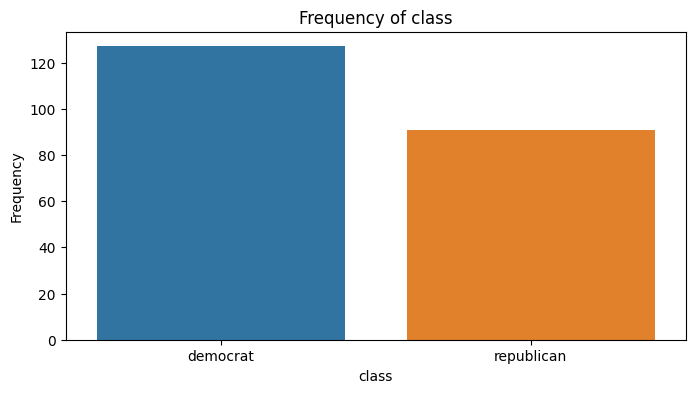

In [171]:
display(df_voting.columns)

display(len(df_voting[df_voting['class']=='republican'])/len(df_voting['class'])*100)
display(len(df_voting[df_voting['class']=='democrat'])/len(df_voting['class'])*100)

plt.figure(figsize=(8, 4))
sns.countplot(x='class', hue='class', data=df_voting)
plt.title('Frequency of class')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

From the frequency table we can see that there are more democrats than republicans in the data set.

handicapped-infants,n,unknown,y,All
class,,,,
democrat,41,3,83,127
republican,68,1,22,91
All,109,4,105,218


water-project-cost-sharing,n,unknown,y,All
class,,,,
democrat,57,15,55,127
republican,33,13,45,91
All,90,28,100,218


adoption-of-the-budget-resolution,n,unknown,y,All
class,,,,
democrat,8,6,113,127
republican,79,2,10,91
All,87,8,123,218


physician-fee-freeze,n,unknown,y,All
class,,,,
democrat,117,5,5,127
republican,2,1,88,91
All,119,6,93,218


el-salvador-aid,n,unknown,y,All
class,,,,
democrat,100,6,21,127
republican,4,1,86,91
All,104,7,107,218


religious-groups-in-schools,n,unknown,y,All
class,,,,
democrat,69,5,53,127
republican,7,1,83,91
All,76,6,136,218


anti-satellite-test-ban,n,unknown,y,All
class,,,,
democrat,25,4,98,127
republican,68,3,20,91
All,93,7,118,218


aid-to-nicaraguan-contras,n,unknown,y,All
class,,,,
democrat,17,3,107,127
republican,72,9,10,91
All,89,12,117,218


mx-missile,n,unknown,y,All
class,,,,
democrat,27,7,93,127
republican,80,1,10,91
All,107,8,103,218


immigration,n,unknown,y,All
class,,,,
democrat,71,2,54,127
republican,45,1,45,91
All,116,3,99,218


synfuels-crporation-cutback,n,unknown,y,All
class,,,,
democrat,61,6,60,127
republican,73,4,14,91
All,134,10,74,218


education-spending,n,unknown,y,All
class,,,,
democrat,103,11,13,127
republican,11,7,73,91
All,114,18,86,218


superfund-right-to-sue,n,unknown,y,All
class,,,,
democrat,83,8,36,127
republican,9,8,74,91
All,92,16,110,218


crime,n,unknown,y,All
class,,,,
democrat,82,5,40,127
republican,2,6,83,91
All,84,11,123,218


duty-free-exports,n,unknown,y,All
class,,,,
democrat,41,6,80,127
republican,75,8,8,91
All,116,14,88,218


export-administration-act-south-africa,n,unknown,y,All
class,,,,
democrat,4,41,82,127
republican,25,13,53,91
All,29,54,135,218


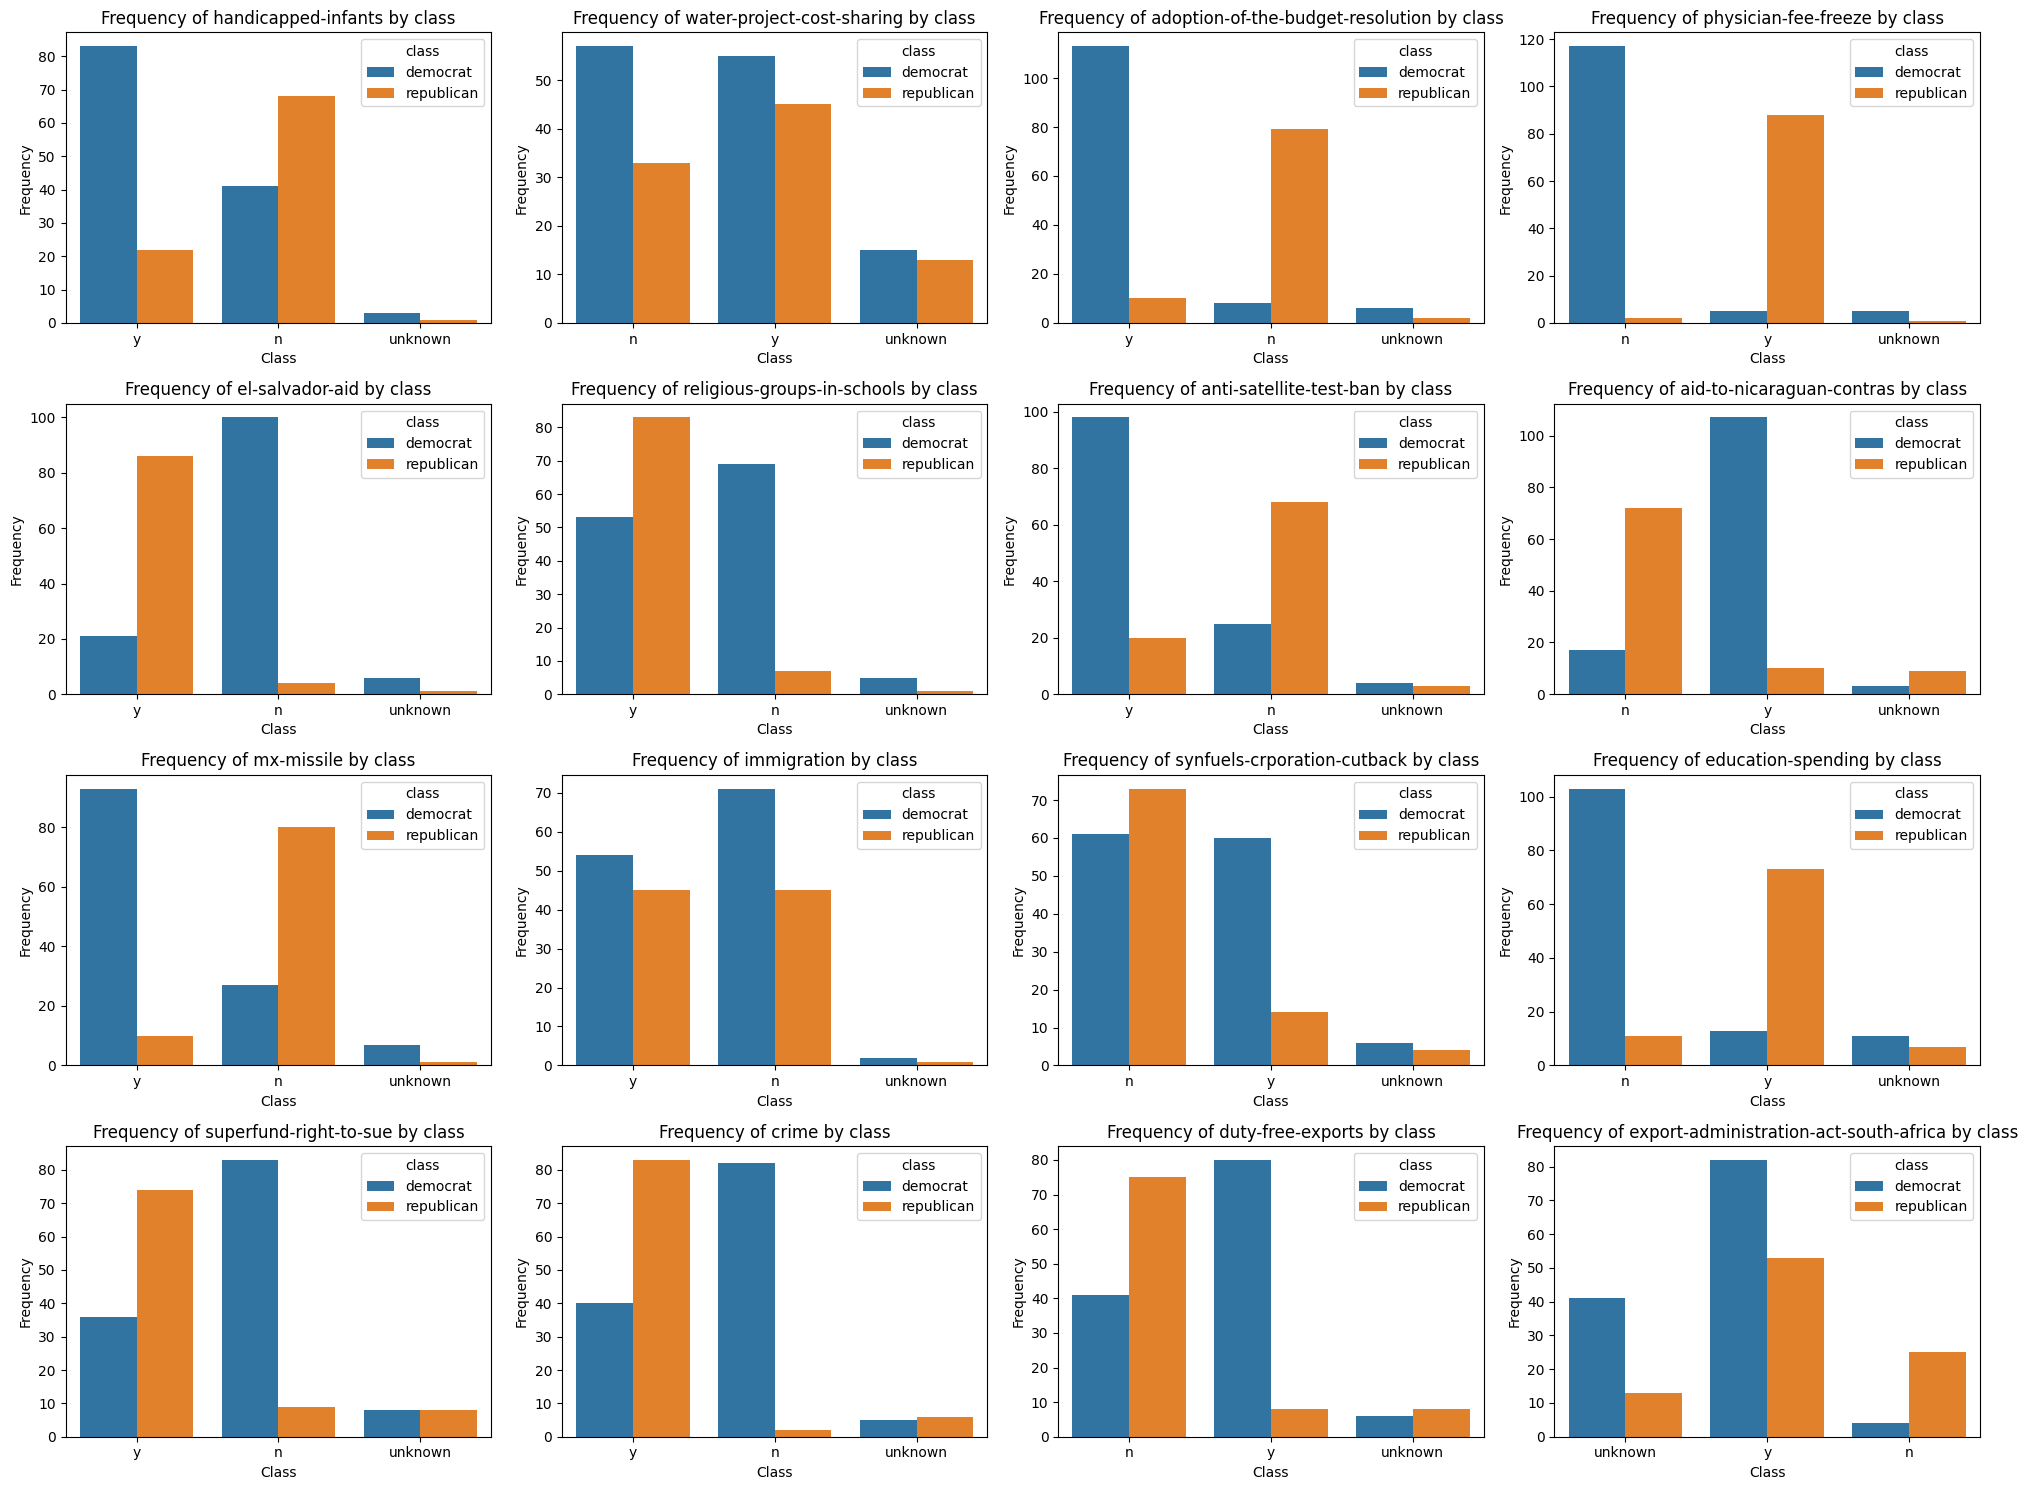

In [172]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()

for j, i in enumerate(df_voting.columns[2:]):  # Limits to 16 columns
    contingency_table = pd.crosstab(index=df_voting['class'], columns=df_voting[i], margins=True)
    display(contingency_table)
    
    sns.countplot(x=i, hue='class', data=df_voting, ax=axes[j])
    axes[j].set_title(f'Frequency of {i} by class')
    axes[j].set_xlabel('Class')
    axes[j].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

From the contingency tables we can get a grasp which attributes might indicate the best how an answer to a specific question could predict the class of the voter. For example adoption-of-the-budget-resolution was highly answered with "no" by republicans and "yes" by democrats while physician-fee-freeze was highly answered with "no" by democrats and "yes by republicans. Some questions are nearly balanced out and are harder to determine if the voter is going to vote democrat or republican. E.g. synfuels-crporation-cutback.

## Pre processing

We want to use for our data sets these three clasifiers:
1. Random Forrests
2. Support Vector Machines
3. Multilayer Perceptron

The classifier 1. could handle our missing value "unknown" but for the classifiers 2. and 3. we need fully numeric data. So we change democrat to 0 and republican to 1; n to 0, y to 1 and unknown to 2. We keep the missing values as a category because it contains information that can be important for the model. For different experiments we can choose to impute the missing value with the majority vote in the column and then work with this data set.

In [173]:
df_voting = df_voting.replace("democrat", 0).replace("republican", 1)
df_voting = df_voting.replace("n", 0).replace("y", 1).replace("unknown", 2)

display(df_voting)

,ID,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,362,0,1,0,1,0,1,1,1,0,1,1,0,0,1,1,0,2
1,86,0,0,0,1,0,1,1,0,0,0,1,1,1,1,1,0,1
2,264,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1,2
3,258,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,2,1
4,381,0,1,1,1,0,0,1,2,1,1,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,209,0,0,0,1,0,0,0,1,1,1,0,0,2,0,0,1,1
214,184,0,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2
215,309,1,0,0,0,1,1,1,0,0,0,1,0,1,1,1,0,0
216,348,1,1,0,0,1,1,1,0,0,0,1,0,1,1,1,0,0


### Outliers

In [174]:
#Identify Outliers

numeric_columns = df_voting.select_dtypes(include='number').columns
# Identify outliers using the IQR method
Q1 = df_voting[numeric_columns].quantile(0.25)
Q3 = df_voting[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Step 3: Identifying outliers
outlier_info = {}  # Dictionary to hold outlier information

for column in numeric_columns:
    outlier_condition = (df_voting[column] < (Q1[column] - 1.5 * IQR[column])) | \
                        (df_voting[column] > (Q3[column] + 1.5 * IQR[column]))
    
    # If there are any outliers for the current column
    if outlier_condition.any():
        outlier_indices = df_voting[outlier_condition].index.tolist()  # Get the indices of outliers
        outlier_values = df_voting.loc[outlier_condition, column].values.tolist()  # Get the outlier values
        outlier_info[column] = {'indices': outlier_indices, 'values': outlier_values}

# Step 4: Print outlier information
print("\n eventual outliers Found in Each Column:")
#for column, info in outlier_info.items():
  #  print(f"Column '{column}':")
  #  for i, value in zip(info['indices'], info['values']):
    #    print(f"  Row {i}: Outlier Value = {value}")

# Summary of the number of outliers per column
print("\nSummary of Outliers by Column:")
for column, info in outlier_info.items():
    print(f"Column '{column}' has {len(info['indices'])} outliers.")


 eventual outliers Found in Each Column:

Summary of Outliers by Column:
Column 'export-administration-act-south-africa' has 83 outliers.


### Test-Train Split and scaling

In [181]:
X = df_voting.drop(['class'], axis=1)

y = df_voting['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, 
                                                                    test_size=0.35, shuffle=True)
display(len(X_train))

141

## Classifier 1. Random Forrest

### Hyperparameter tuning using grid search

In [184]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['sqrt', 'log2'],
               'max_depth': [2, 5, 10, 15, 20],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf_model = RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 10, 15, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

### Try different parameter combinations

In [207]:
random_1 = RandomForestClassifier(n_estimators = 1000, max_features = 'log2', max_depth = 500, min_samples_split = 200, min_samples_leaf = 200, bootstrap = False)
random_1.fit(X_train, y_train)

random_2 = RandomForestClassifier(n_estimators = 600, max_features = 'sqrt', max_depth = 65, min_samples_leaf = 30, bootstrap = True, criterion='log_loss')
random_2.fit(X_train, y_train)

def evaluate_classification(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy * 100))
    print('Classification Report:')
    print(classification_report(y_test, predictions, zero_division=1))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions))
    
    return accuracy

random_1_accuracy = evaluate_classification(random_1, X_test, y_test)
random_2_accuracy = evaluate_classification(random_2, X_test, y_test)
best_accuracy = evaluate_classification(rf_model.best_estimator_, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_2_accuracy - random_1_accuracy) / random_1_accuracy))
print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - random_2_accuracy) / random_2_accuracy))


Model Performance
Accuracy = 54.55%.
Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        42
           1       1.00      0.00      0.00        35

    accuracy                           0.55        77
   macro avg       0.77      0.50      0.35        77
weighted avg       0.75      0.55      0.39        77

Confusion Matrix:
[[42  0]
 [35  0]]
Model Performance
Accuracy = 96.10%.
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.97      0.94      0.96        35

    accuracy                           0.96        77
   macro avg       0.96      0.96      0.96        77
weighted avg       0.96      0.96      0.96        77

Confusion Matrix:
[[41  1]
 [ 2 33]]
Model Performance
Accuracy = 97.40%.
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00    

## Classifier 2. Support Vector Machines

In [123]:
params_grid_svm = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
    {'kernel': ['poly'], 'degree': [2, 3], 'C': [1, 10, 100, 1000]}
]

svm_model = GridSearchCV(SVC(), params_grid_svm, cv=5)

## Classifier 3. Multilayer Percepton

In [112]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'max_iter': [1500, 2000, 2500, 3000],
    'learning_rate': ['constant','adaptive'],
}

mlp_model = GridSearchCV(MLPClassifier(), param_grid=param_grid, cv=5, n_jobs=-1)

In [124]:
def fitting_models(X_train, y_train):

    svm_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    mlp_model.fit(X_train, y_train)

def evaluate_classification(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy * 100))
    print('Classification Report:')
    print(classification_report(y_test, predictions, zero_division=1))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions))
    
    return accuracy

fitting_models(X_train, y_train)

## Evaluation

In [125]:
final_model = rf_model.best_estimator_

evaluate_classification(rf_model, X_test, y_test)
evaluate_classification(final_model, X_test, y_test)

Model Performance
Accuracy = 98.18%.
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      0.96      0.98        24

    accuracy                           0.98        55
   macro avg       0.98      0.98      0.98        55
weighted avg       0.98      0.98      0.98        55

Confusion Matrix:
[[31  0]
 [ 1 23]]
Model Performance
Accuracy = 98.18%.
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        31
           1       1.00      0.96      0.98        24

    accuracy                           0.98        55
   macro avg       0.98      0.98      0.98        55
weighted avg       0.98      0.98      0.98        55

Confusion Matrix:
[[31  0]
 [ 1 23]]


0.9818181818181818

In [126]:
final_model = svm_model.best_estimator_

evaluate_classification(svm_model, X_test, y_test)
evaluate_classification(final_model, X_test, y_test)

Model Performance
Accuracy = 92.73%.
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        31
           1       0.95      0.88      0.91        24

    accuracy                           0.93        55
   macro avg       0.93      0.92      0.93        55
weighted avg       0.93      0.93      0.93        55

Confusion Matrix:
[[30  1]
 [ 3 21]]
Model Performance
Accuracy = 92.73%.
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        31
           1       0.95      0.88      0.91        24

    accuracy                           0.93        55
   macro avg       0.93      0.92      0.93        55
weighted avg       0.93      0.93      0.93        55

Confusion Matrix:
[[30  1]
 [ 3 21]]


0.9272727272727272

In [129]:
final_model = mlp_model.best_estimator_

evaluate_classification(mlp_model, X_test, y_test)
evaluate_classification(final_model, X_test, y_test)

Model Performance
Accuracy = 49.09%.
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.26      0.36        31
           1       0.45      0.79      0.58        24

    accuracy                           0.49        55
   macro avg       0.53      0.52      0.47        55
weighted avg       0.54      0.49      0.46        55

Confusion Matrix:
[[ 8 23]
 [ 5 19]]
Model Performance
Accuracy = 49.09%.
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.26      0.36        31
           1       0.45      0.79      0.58        24

    accuracy                           0.49        55
   macro avg       0.53      0.52      0.47        55
weighted avg       0.54      0.49      0.46        55

Confusion Matrix:
[[ 8 23]
 [ 5 19]]


0.4909090909090909

In [121]:
df_voting_test = df_voting_test.replace("n", 0).replace("y", 1).replace("unknown", 2)

df_predictions = classifier.predict(df_voting_test)

# Create a DataFrame with the IDs and the predictions ID as the index
df_predictions = pd.DataFrame(df_predictions, index=df_voting_test.index, columns=['class'])

df_predictions = df_predictions.replace(0, "democrat").replace(1, "republican")
    
# Save the DataFrame to a CSV file
df_predictions.to_csv('data/predictions.csv')


For the random forrest classification the accuracy is the biggest and confusion matrix shows that it makes the best predictions. So for the Kaggle competition we choose to commit the preditctions with the random forrest classifier.